In [2]:
import numpy as np 
import pandas as pd 
import bz2
import re
import string
import os


/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


In [3]:
test_file = bz2.BZ2File('test.ft.txt.bz2')
train_file = bz2.BZ2File('train.ft.txt.bz2')

In [4]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [5]:
# delete them to free some ram space 
del train_file, test_file

In [6]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

### extruct the labels for train and test 

In [7]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]


In [8]:
del train_file_lines , test_file_lines

### Create a DataFrame 

In [9]:
df_train = pd.DataFrame({"text" : train_sentences , "target" : train_labels})
df_test = pd.DataFrame({"text" : test_sentences , "target" : test_labels})

In [10]:
del train_sentences , train_labels , test_sentences , test_labels 

In [39]:
df_train = df_train.sample(100000)
df_test = df_test.sample(100000)

### Text Preprocessing 

In [40]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)



def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)


def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 


def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

In [41]:
%time
# apply Remove URLs
df_train["text"] = df_train["text"].apply(lambda x: remove_URL(x))
df_test["text"] = df_test["text"].apply(lambda x: remove_URL(x))

# apply Remove html
df_train["text"] = df_train["text"].apply(lambda x: remove_html(x))
df_test["text"] = df_test["text"].apply(lambda x: remove_html(x))

# apply Remove non-ASCII
df_train["text"] = df_train["text"].apply(lambda x: remove_non_ascii(x))
df_test["text"] = df_test["text"].apply(lambda x: remove_non_ascii(x))

# apply Remove punctuation
df_train["text"] = df_train["text"].apply(lambda x: remove_punct(x))
df_test["text"] = df_test["text"].apply(lambda x: remove_punct(x))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


### Build a Model 

In [42]:
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing import text, sequence

In [43]:
max_features = 20000
maxlen = 100

In [44]:
tokenizer = text.Tokenizer(num_words=max_features)

In [45]:
tokenizer.fit_on_texts(df_train["text"])

In [46]:
tokenized_train = tokenizer.texts_to_sequences(df_train["text"])
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [47]:
tokenized_test = tokenizer.texts_to_sequences(df_test["text"])
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [48]:
from tensorflow.keras.layers import Embedding , LSTM , Dropout , Flatten , Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [82]:
batch_size = 2048
epochs = 5
embed_size = 100

In [83]:
model = Sequential([
Embedding(max_features, embed_size),
LSTM(128 , return_sequences = True , dropout=0.2),
LSTM(64 , dropout=0.1),
Dropout(0.2),
Dense(64 , activation = "relu"),
Dropout(0.1),
Dense(1, activation='sigmoid')])

In [84]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [85]:
# Train the model
hist = model.fit(X_train,
            df_train["target"],
            batch_size=batch_size,
            epochs=epochs, 
            shuffle = True,
            validation_data=(X_test, df_test["target"]))
hist

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.6121 - loss: 0.6513 - val_accuracy: 0.8207 - val_loss: 0.4047
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8552 - loss: 0.3436 - val_accuracy: 0.8831 - val_loss: 0.2819
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9073 - loss: 0.2377 - val_accuracy: 0.8918 - val_loss: 0.2667
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9258 - loss: 0.1961 - val_accuracy: 0.8914 - val_loss: 0.2655
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9365 - loss: 0.1738 - val_accuracy: 0.8889 - val_loss: 0.2875


In [86]:
y_pred = model.predict(X_test) 

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 174s 56ms/step


In [87]:
X_test

array([[ 551,  207, 1195, ...,   15,   10, 1460],
       [   0,    0,    0, ...,   10,  885, 3205],
       [   0,    0,    0, ...,   19,    5,  203],
       ...,
       [   0,    0,    0, ...,  335,    7, 5345],
       [   0,    0,    0, ...,  664, 8150,   43],
       [   0,    0,    0, ...,  115,  117,  706]], dtype=int32)

In [88]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 

In [90]:
cr = classification_report(df_test["target"].values,np.round(y_pred))
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     49814
           1       0.91      0.86      0.89     50186

    accuracy                           0.89    100000
   macro avg       0.89      0.89      0.89    100000
weighted avg       0.89      0.89      0.89    100000



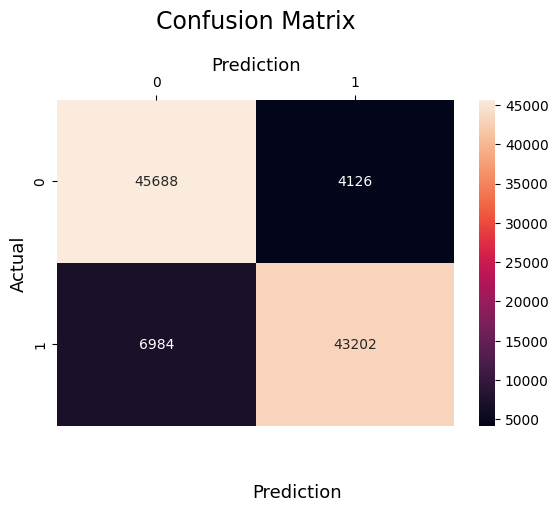

In [89]:
cm = confusion_matrix(df_test["target"].values,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()
